# Brain Tumor Classification using MRI Images

Brain tumors are among the most serious and potentially life-threatening medical conditions, necessitating early and accurate diagnosis. Magnetic Resonance Imaging (MRI) provides a non-invasive means of visualizing brain abnormalities. Automating tumor classification through deep learning models can assist radiologists in diagnosis by providing a second opinion, improving both efficiency and consistency in clinical workflows.

The dataset used in this project, titled "Brain Tumor MRI Dataset," contains labeled MRI images categorized into four classes: glioma, meningioma, pituitary tumor, and healthy (no tumor). It is organized into distinct training and testing directories and is publicly available on Kaggle (https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Constants
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 20
NUM_CLASSES = 4
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

## Data Preprocessing
Before training, all MRI images are resized to a uniform resolution of 256x256 pixels and normalized by scaling pixel values to the [0,1] range. Normalization accelerates model convergence and stabilizes learning. Labels are encoded categorically to support multi-class classification.

Additionally, data was split into training and validation subsets using a 15% validation split from the training data. This allows for real-time monitoring of model generalization during training.

To improve model robustness and reduce overfitting, the training images are subjected to a variety of augmentation techniques. These augmentations simulate natural variations in MRI scans, such as changes in orientation, brightness, or positioning. This effectively increases the diversity of the training set and allows the model to learn more generalized features.

Moreover, class imbalance was addressed by computing class weights, ensuring the model does not become biased toward more frequent tumor types.

In [4]:
def create_data_generators():
    """Create optimized data generators with class balancing"""
    # Calculate class weights
    train_counts = {}
    for cls in CLASS_NAMES:
        path = os.path.join("Brain_tumor_data/Training", cls)
        train_counts[cls] = len(os.listdir(path))
    
    print("\nClass distribution in training set:")
    for cls, count in train_counts.items():
        print(f"{cls}: {count} samples")
    
    total = sum(train_counts.values())
    class_weights = {i: total/(len(train_counts)*count) 
                    for i, count in enumerate(train_counts.values())}
    
    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='reflect',
        validation_split=0.15
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        "Brain_tumor_data/Training",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    val_generator = train_datagen.flow_from_directory(
        "Brain_tumor_data/Training",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )
    
    test_generator = test_datagen.flow_from_directory(
        "Brain_tumor_data/Testing",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator, class_weights

## Model Architecture and Training
The classification model is based on the ResNet50V2 architecture, pretrained on ImageNet. Transfer learning was employed to leverage the robust feature extraction capabilities of this network. The first half of the ResNet layers were frozen to preserve learned low-level features, while the remaining layers were fine-tuned on the MRI dataset.

Additional layers were appended to the base model:
- Global Average Pooling to reduce spatial dimensions.
- Dense layers with batch normalization and dropout for regularization.
- Final dense layer with softmax activation to output class probabilities.

To prevent overfitting and accelerate convergence, the model incorporated:
- L1/L2 regularization,
- Dropout layers,
- Learning rate scheduling via exponential decay,
- Early stopping based on validation accuracy,
- ReduceLROnPlateau to adjust learning rate upon stagnation,
- Model checkpointing to preserve the best-performing model.

In [5]:
def build_model():
    """Build a CNN model for brain tumor classification."""
    base_model = ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=IMAGE_SIZE + (3,),
        pooling=None
    )
    
    # Freeze first 50% of layers, unfreeze the rest
    for layer in base_model.layers[:len(base_model.layers)//2]:
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # Learning rate with exponential decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=3e-4,
        decay_steps=train_generator.samples // BATCH_SIZE * 5,  # Decay every 5 epochs
        decay_rate=0.9,
        staircase=True
    )
    
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
def plot_history(history):
    """Plot training history"""
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [7]:
def visualize_predictions(model, generator, num_samples=8):
    """Visualize sample images with actual and predicted labels"""
    # Get a batch of data
    images, true_labels = next(generator)
    
    # Make predictions
    preds = model.predict(images)
    true_classes = np.argmax(true_labels, axis=1)
    pred_classes = np.argmax(preds, axis=1)
    pred_probs = np.max(preds, axis=1)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        
        true_label = CLASS_NAMES[true_classes[i]]
        pred_label = CLASS_NAMES[pred_classes[i]]
        confidence = pred_probs[i]
        
        title_color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", 
                 color=title_color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
def evaluate_model(model, test_gen):
    """Evaluate model performance with visual samples"""
    # Load best weights
    model.load_weights('best_model.h5')
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Generate predictions
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(test_gen.classes, y_pred_classes, 
                              target_names=CLASS_NAMES))
    
    # Confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Visualize sample predictions
    print("\nSample Predictions:")
    visualize_predictions(model, test_gen)


Class distribution in training set:
glioma: 1321 samples
meningioma: 1339 samples
notumor: 1595 samples
pituitary: 1457 samples
Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
   

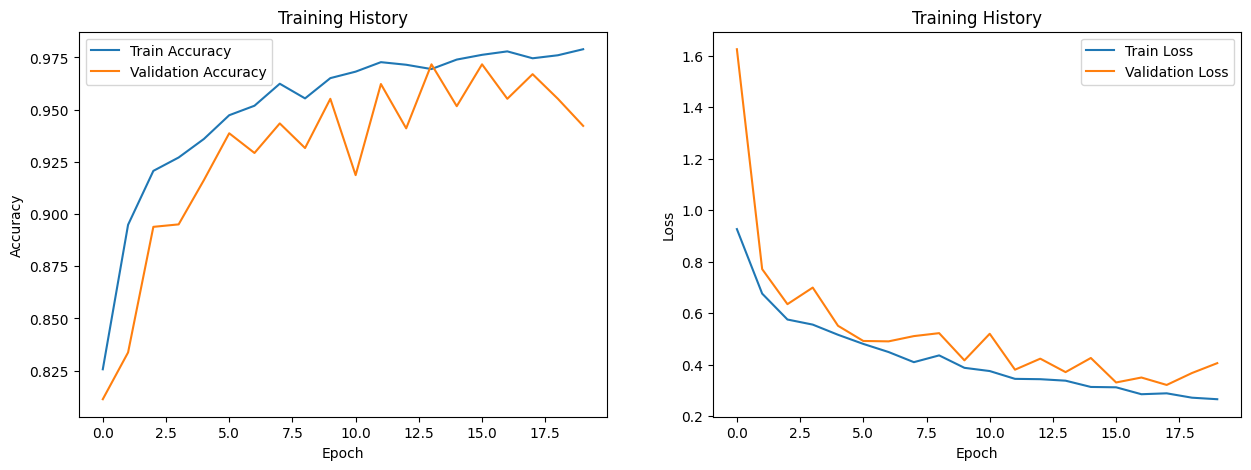

82/82 [==============================] - 18s 223ms/step - loss: 0.3300 - accuracy: 0.9733

Test Accuracy: 0.9733
Test Loss: 0.3300
82/82 [==============================] - 19s 220ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.92      0.96       300
  meningioma       0.94      0.98      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



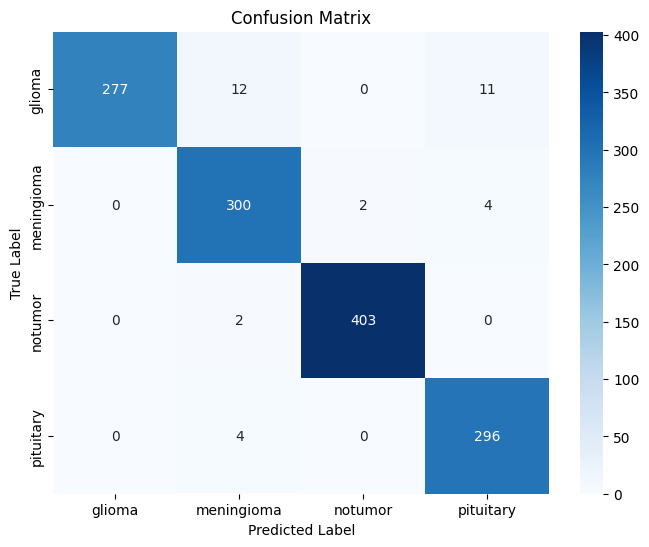


Sample Predictions:
1/1 [==============================] - 1s 619ms/step


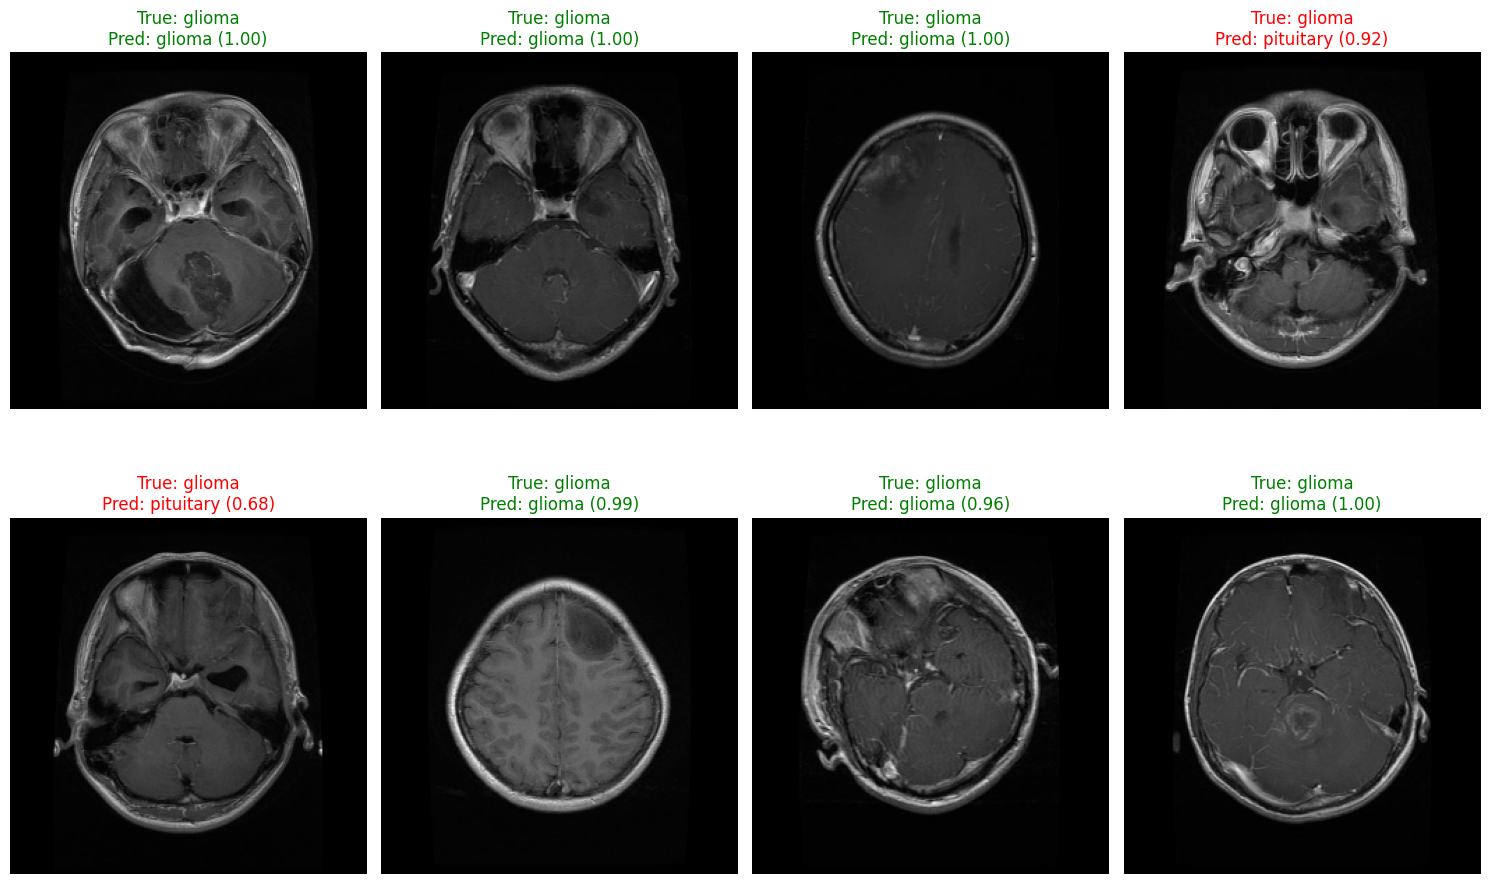

In [9]:
if __name__ == "__main__":
    # Load and prepare data
    train_generator, val_generator, test_generator, class_weights = create_data_generators()
    
    # Build model
    model = build_model()
    model.summary()
    
    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        class_weight=class_weights,
        callbacks=[
            EarlyStopping(monitor='val_accuracy', patience=8, mode='max', verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            ModelCheckpoint('best_model.h5', monitor='val_accuracy', 
                          save_best_only=True, mode='max')
        ]
    )
    
    # Plot and evaluate results
    plot_history(history)
    evaluate_model(model, test_generator)

## Evaluation and Results
The model achieved a test accuracy of 97.33% and a low test loss of 0.33. The classification report and confusion matrix reveal strong performance across all four classes, with precision and recall exceeding 94% for each category. Notably, the “no tumor” class achieved perfect recall, indicating the model’s potential utility in minimizing false negatives in a clinical setting.

Sample prediction visualizations provided further qualitative insights, showing that the model consistently assigned high confidence scores to correct predictions and that misclassifications were rare and generally involved visually ambiguous cases.

## Conclusion
This project successfully developed a deep learning model for multi-class brain tumor classification using MRI data. The combination of transfer learning, careful augmentation, and regularization contributed to its effectiveness and generalization capability. Given its performance, the model has potential for integration into computer-aided diagnostic systems, especially in environments with limited radiological expertise. Future work could involve extending the model to handle multi-modal MRI data or testing its robustness on external datasets to assess real-world applicability.